# RF Poincare

In [1]:
import glob
import imageio
import numpy as np
import PyNAFF as pnf
import scipy.io as sio 
import matplotlib.cm as cm
from math import log10, floor
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy.optimize import curve_fit
import matplotlib.gridspec as gridspec

In [2]:
plt.rcParams['figure.figsize'] = [5.0, 4.5]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 1

### Function Definitions

In [3]:
def round_sig(x, sig=4):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [4]:
def add_input_file(dd, filename, label):
	f = filename
	p = dict()
	sio.loadmat(f, mdict=p)
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [5]:
def add_bunch_file(dd, filename, label):
	f = filename
	p = sio.loadmat(f, squeeze_me=True,  struct_as_record=False)['particles']
	dd[label] = p
	print '\tAdded output data from ', filename, '\t dictionary key: ', label
	return dd

In [6]:
class resonance_lines(object):
	
	def __init__(self, Qx_range, Qy_range, orders, periodicity):
		
		if np.std(Qx_range):
			self.Qx_min = np.min(Qx_range)
			self.Qx_max = np.max(Qx_range)
		else:
			self.Qx_min = np.floor(Qx_range)-0.05
			self.Qx_max = np.floor(Qx_range)+1.05
		if np.std(Qy_range):
			self.Qy_min = np.min(Qy_range)
			self.Qy_max = np.max(Qy_range)
		else:
			self.Qy_min = np.floor(Qy_range)-0.05
			self.Qy_max = np.floor(Qy_range)+1.05

		self.periodicity = periodicity
									
		nx, ny = [], []

		for order in np.nditer(np.array(orders)):
			t = np.array(range(-order, order+1))
			nx.extend(order - np.abs(t))
			ny.extend(t)
		nx = np.array(nx)
		ny = np.array(ny)
	
		cextr = np.array([nx*np.floor(self.Qx_min)+ny*np.floor(self.Qy_min), \
						  nx*np.ceil(self.Qx_max)+ny*np.floor(self.Qy_min), \
						  nx*np.floor(self.Qx_min)+ny*np.ceil(self.Qy_max), \
						  nx*np.ceil(self.Qx_max)+ny*np.ceil(self.Qy_max)], dtype='int')
		cmin = np.min(cextr, axis=0)
		cmax = np.max(cextr, axis=0)
		res_sum = [range(cmin[i], cmax[i]+1) for i in xrange(cextr.shape[1])]								
		self.resonance_list = zip(nx, ny, res_sum)
		
	def plot_resonance(self, figure_object = None):	
		plt.ion()
		if figure_object:
			fig = figure_object
			plt.figure(fig.number)
		else:
			fig = plt.figure()
		Qx_min = self.Qx_min
		Qx_max = self.Qx_max
		Qy_min = self.Qy_min
		Qy_max = self.Qy_max 
		plt.xlim(Qx_min, Qx_max)
		plt.ylim(Qy_min, Qy_max)
		plt.xlabel('Qx')
		plt.ylabel('Qy')
		for resonance in self.resonance_list:
			nx = resonance[0]
			ny = resonance[1]
			for res_sum in resonance[2]:
				if ny:
					line, = plt.plot([Qx_min, Qx_max], \
					    [(res_sum-nx*Qx_min)/ny, (res_sum-nx*Qx_max)/ny])
				else:
					line, = plt.plot([np.float(res_sum)/nx, np.float(res_sum)/nx],[Qy_min, Qy_max])
				if ny%2:
					plt.setp(line, linestyle='--') # for skew resonances
				if res_sum%self.periodicity:
					plt.setp(line, color='b')	# non-systematic resonances
				else:
					plt.setp(line, color='r', linewidth=2.0) # systematic resonances
		plt.draw()
		return fig
		
	def print_resonances(self):
		for resonance in self.resonance_list:
			for res_sum in resonance[2]:
				'''
				print str(resonance[0]).rjust(3), 'Qx ', ("+", "-")[resonance[1]<0], \
					  str(abs(resonance[1])).rjust(2), 'Qy = ', str(res_sum).rjust(3), \
					  '\t', ("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0]
				'''
				print '%s %s%s = %s\t%s'%(str(resonance[0]).rjust(2), ("+", "-")[resonance[1]<0], \
						str(abs(resonance[1])).rjust(2), str(res_sum).rjust(4), \
						("(non-systematic)", "(systematic)")[res_sum%self.periodicity==0])


In [7]:
def LorentzGamma(E_tot, E_rest=938.27208816E6):
    return (E_tot / E_rest)
    
def LorentzGamma_from_beta(beta=0.9476):
    return (1./np.sqrt(1.-beta**2))    

def LorentzBeta(gamma):
    return np.sqrt( 1. - (1./gamma**2) )

def RelativisticMomentum(gamma, E_rest=938.27208816E6):
    return (gamma * E_rest * LorentzBeta(gamma))

def z_to_time(z, beta=0.9476): 
    c = 299792458
    return z / (c * beta)
    
def E_from_gamma(gamma, E_rest=938.27208816E6):
    return (gamma*E_rest)

def dpp_from_dE(dE, E=2.938E9, beta=0.9476):
    return (dE / (E * beta**2))
    
def dE_from_dpp(dpp, E=2.938E9, beta=0.9476):
    return (dpp * E * beta**2)

In [8]:
def seq_start_to_end(n_vals, start, stop):
    n_mp = n_vals
    interval = (stop-start)/(n_mp-1) 

    print('seq_start_to_end::interval = ', interval)

    positions = np.arange(start, stop+interval, interval)
    
    return positions

def seq_even_about_start(n_vals, start, stop):
    n_mp = n_vals
    interval = 2*(stop-start)/(n_mp-1) 

    positive = np.arange(start, stop+interval, interval)
    negative = np.arange((-1*stop), start, interval)

    positions = np.concatenate((negative, positive), axis=None)
    
    return positions

In [9]:
def Read_Particle_File(filename):
    dtype1 = np.dtype([('ID', 'i4'), ('Turn', 'i4'), ('x', 'f8'), ('xp', 'f8'), ('y', 'f8'), ('yp', 'f8'), ('z', 'f8'), ('dE', 'f8')])
    return np.loadtxt(filename, dtype=dtype1, skiprows=1)
    

In [10]:
# PS Pre-LIU 1.4 GeV Injection
LIU = True

if LIU:
    print 'PS LIU 2 GeV Injection'
    Lorentz_Gamma = 3.1316
    
else:
    print 'PS Pre-LIU 1.4 GeV Injection'
    Lorentz_Gamma = 2.4921
        
print '----------------------'
print 'Lorentz Gamma =\t', Lorentz_Gamma
Lorentz_Beta = LorentzBeta(Lorentz_Gamma)
print 'Lorentz Beta =\t', round_sig(Lorentz_Beta)
Beam_Energy = E_from_gamma(Lorentz_Gamma)
print 'Energy =\t', round_sig(Beam_Energy/1E9), 'GeV'
Beam_Momentum = RelativisticMomentum(938.27208816E6, Lorentz_Gamma)
print 'Momentum =\t', round_sig(Beam_Momentum)/1E9, 'GeV/c'


PS LIU 2 GeV Injection
----------------------
Lorentz Gamma =	3.1316
Lorentz Beta =	0.9476
Energy =	2.938 GeV
Momentum =	2.938 GeV/c


## Test Read_Particle_File

In [11]:
dd = Read_Particle_File('Particle_5.dat')
turn = 0
print dd['x'][turn]
print dd['xp'][turn]
print dd['y'][turn]
print dd['yp'][turn]
print dd['z'][turn]
print dd['dE'][turn]

-0.005078
-0.0003
0.0
0.0
-0.107415
-0.005937


## Plot single file

### Single file z dE

In [14]:
len(dd['z'])

1000

('seq_start_to_end::interval = ', 1)


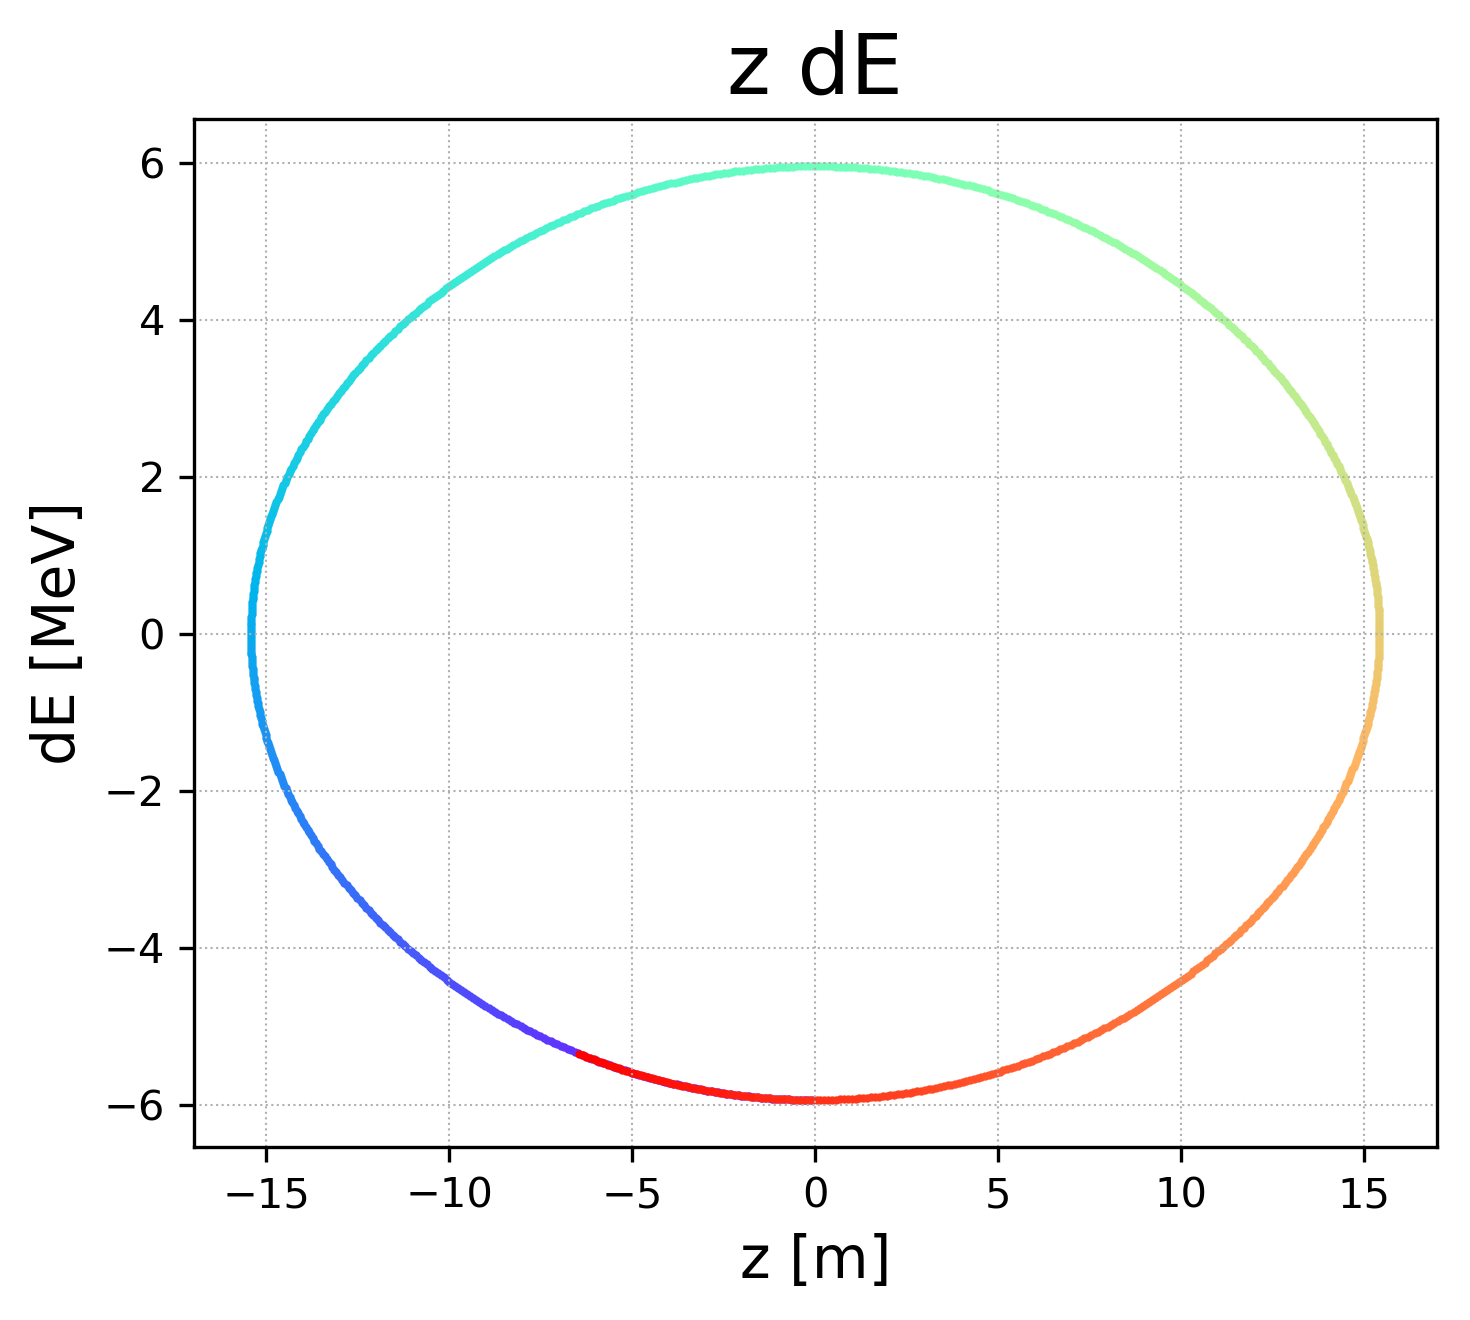

In [12]:
parameter1 = 'z'
parameter2 = 'dE'
multi1 = 1
multi2 = 1E3

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = parameter1 + ' ' + parameter2
ax1.set_title(tit);

ax1.set_ylabel('dE [MeV]');
ax1.set_xlabel('z [m]');

colors = cm.rainbow(np.linspace(0, 1, len(dd[parameter1])))
c_it = int(0)

turns = seq_start_to_end(len(dd[parameter1]), 0, len(dd[parameter1])-1)

for t in turns:
    ax1.scatter(dd[parameter1][t]*multi1, dd[parameter2][t]*multi2, color=colors[c_it]);
    c_it = c_it + 1;


#ax2 = ax1.twinx()
#ax2.plot((dd[key][parameter][0]*multi/np.mean(dd[key][parameter][0]*multi)*100)-100, color='r', alpha=0)
#ax2.set_ylabel(r'$\frac{\sigma_{x}}{\left< \sigma_{x} \right>}$ [%]')

#ax1.legend(loc=3)
ax1.grid(lw=0.5, ls=':');
#ax1.set_xlim(-1,turn_tot)

fig1.tight_layout()

#savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
#plt.savefig(savename, dpi = 800);


### single file t dpp

('seq_start_to_end::interval = ', 1)


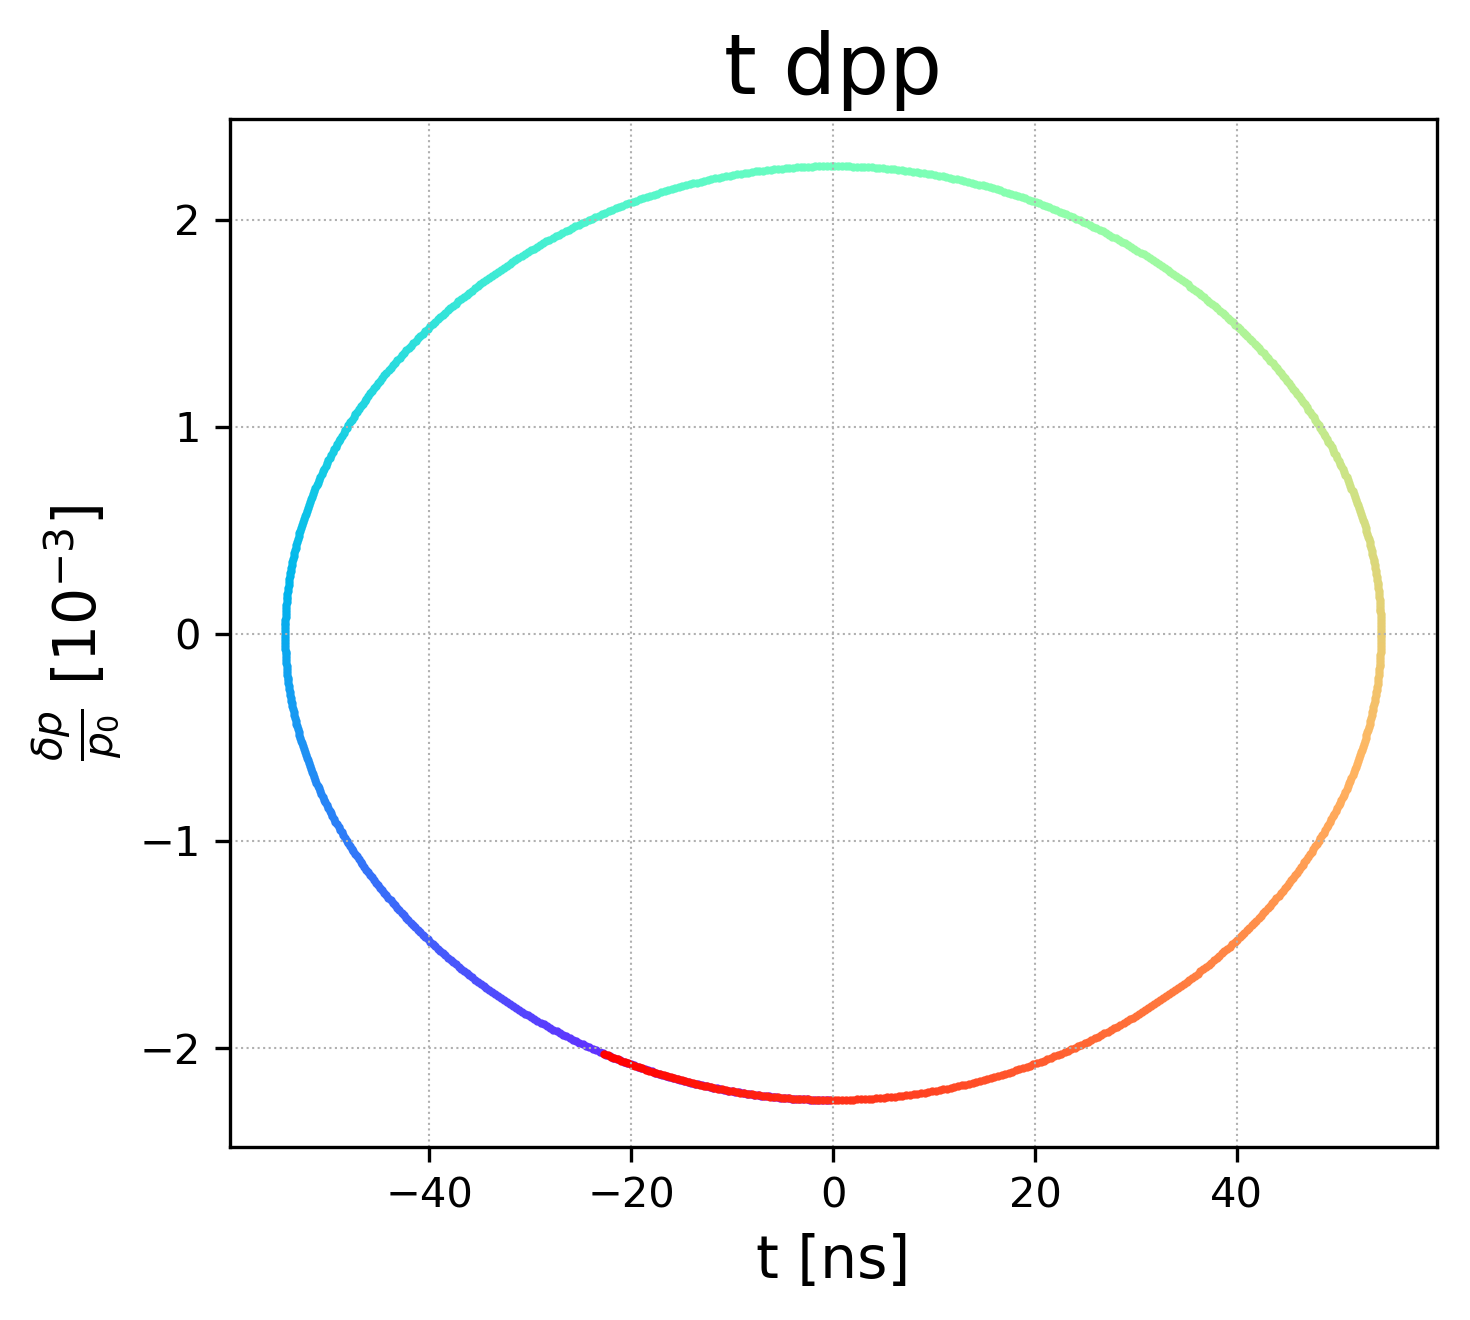

In [13]:
parameter1 = 'z'
parameter2 = 'dE'
multi1 = 1E9
multi2 = 1E3

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 't dpp'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\delta p}{p_0}$ $[10^{-3}]$');
ax1.set_xlabel('t [ns]');

colors = cm.rainbow(np.linspace(0, 1, len(dd[parameter1])))
c_it = int(0)

turns = seq_start_to_end(len(dd[parameter1]), 0, len(dd[parameter1])-1)

for t in turns:
    ax1.scatter(z_to_time(dd[parameter1][t])*multi1, dpp_from_dE(dd[parameter2][t]*1E9)*multi2, color=colors[c_it]);
    #print dpp_from_dE(dd[parameter2][t])*multi2
    c_it = c_it + 1;


#ax2 = ax1.twinx()
#ax2.plot((dd[key][parameter][0]*multi/np.mean(dd[key][parameter][0]*multi)*100)-100, color='r', alpha=0)
#ax2.set_ylabel(r'$\frac{\sigma_{x}}{\left< \sigma_{x} \right>}$ [%]')

#ax1.legend(loc=3)
ax1.grid(lw=0.5, ls=':');
#ax1.set_xlim(-1,turn_tot)

fig1.tight_layout()

#savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
#plt.savefig(savename, dpi = 800);


# Plot multiple files

## Load files

In [15]:
# Make a list of all Particle_*.dat files
Particle_Files = []
for name in glob.glob('Particle_*.dat'):
    Particle_Files.append(name)
    
print sorted(Particle_Files)

['Particle_0.dat', 'Particle_1.dat', 'Particle_10.dat', 'Particle_11.dat', 'Particle_12.dat', 'Particle_13.dat', 'Particle_14.dat', 'Particle_15.dat', 'Particle_16.dat', 'Particle_17.dat', 'Particle_18.dat', 'Particle_19.dat', 'Particle_2.dat', 'Particle_20.dat', 'Particle_3.dat', 'Particle_4.dat', 'Particle_5.dat', 'Particle_6.dat', 'Particle_7.dat', 'Particle_8.dat', 'Particle_9.dat']


In [16]:
# Load data into a dicitonary (of dictionaries returned by Read_Particle_File)
ddd = dict()
for f in Particle_Files:
    ddd[int(f.split('_')[1].split('.')[0])] = Read_Particle_File(f)

# Access like
ddd[18]['x'][0]

0.008399

('seq_start_to_end::interval = ', 1)


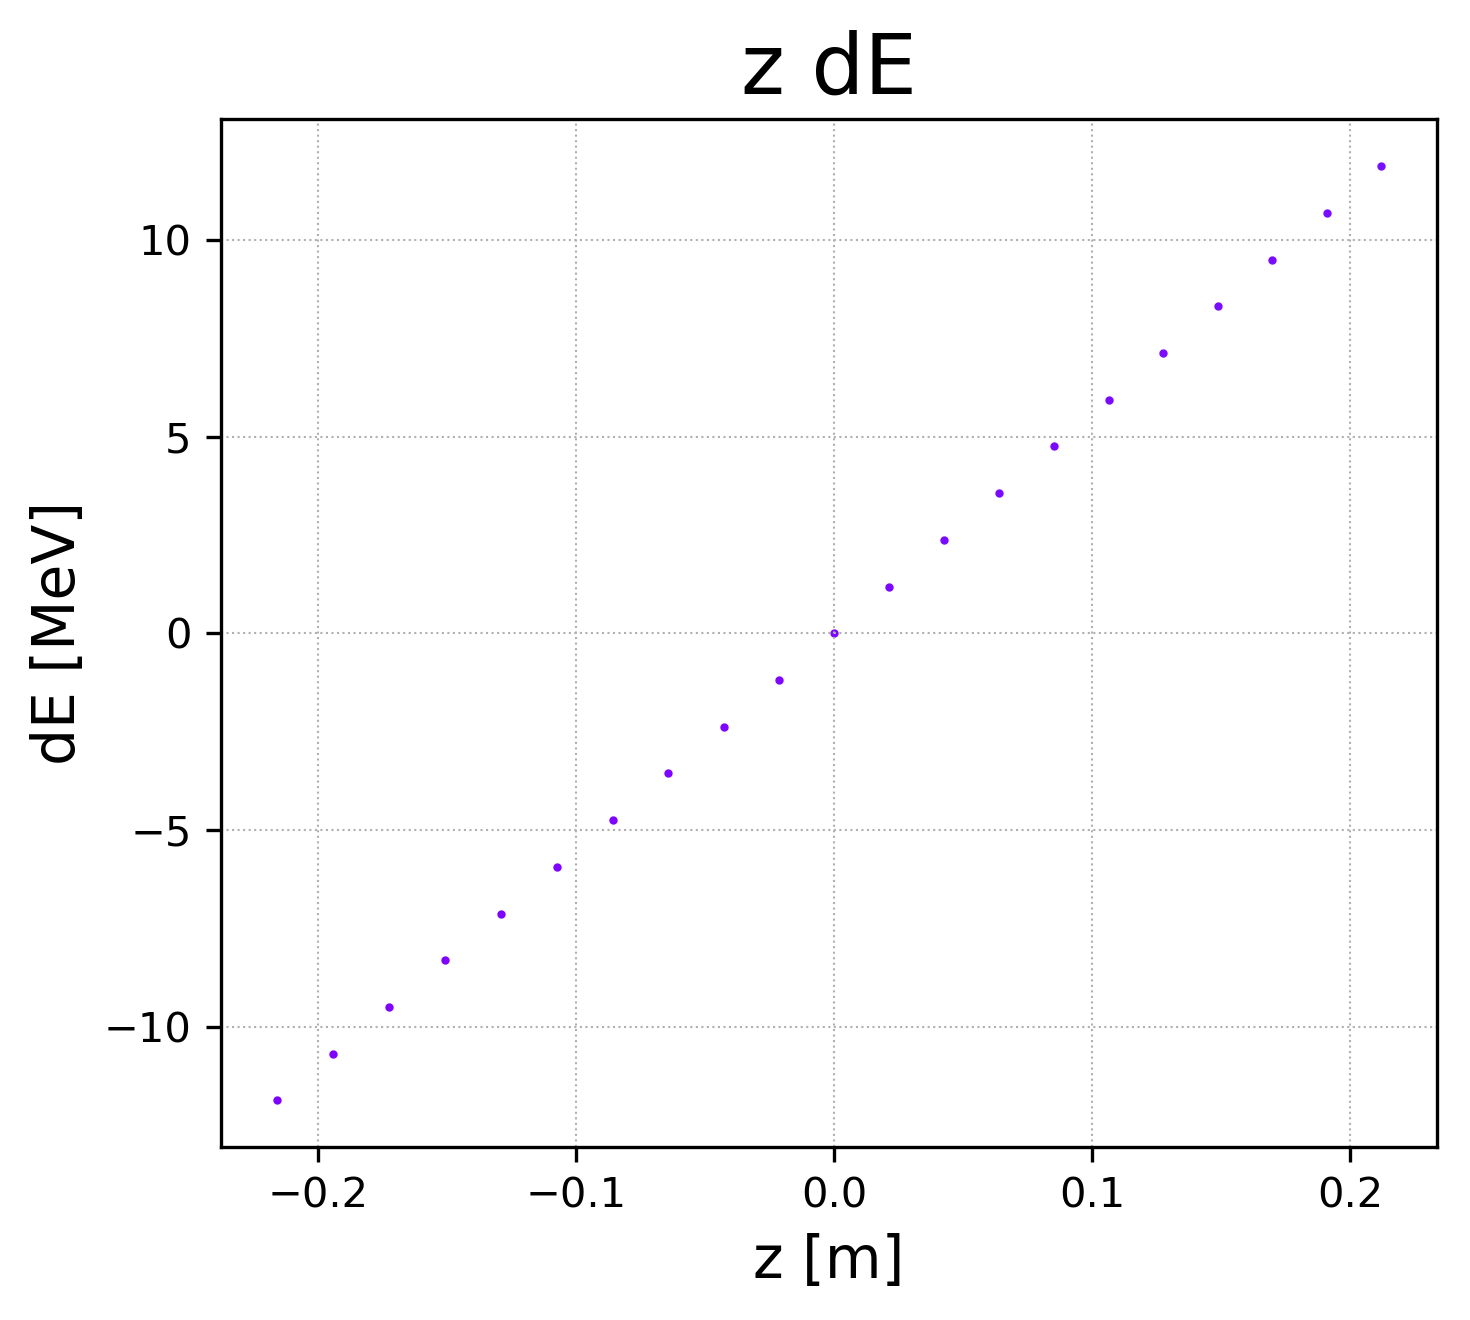

In [28]:
parameter1 = 'z'
parameter2 = 'dE'
multi1 = 1
multi2 = 1E3

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = parameter1 + ' ' + parameter2
ax1.set_title(tit);

ax1.set_ylabel('dE [MeV]');
ax1.set_xlabel('z [m]');

colors = cm.rainbow(np.linspace(0, 1, len(dd[parameter1])))
c_it = int(0)

turns = seq_start_to_end(len(dd[parameter1]), 0, len(dd[parameter1])-1)

for key, value in sorted(ddd.iteritems()):
    t=0
    ax1.scatter(ddd[key][parameter1][t]*multi1, ddd[key][parameter2][t]*multi2, color=colors[c_it]);
    c_it = c_it + 1;
    #c_it = 0;

#ax1.legend(loc=3)
ax1.grid(lw=0.5, ls=':');
#ax1.set_xlim(-1,turn_tot)

fig1.tight_layout()

#savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
#plt.savefig(savename, dpi = 800);

('seq_start_to_end::interval = ', 1)


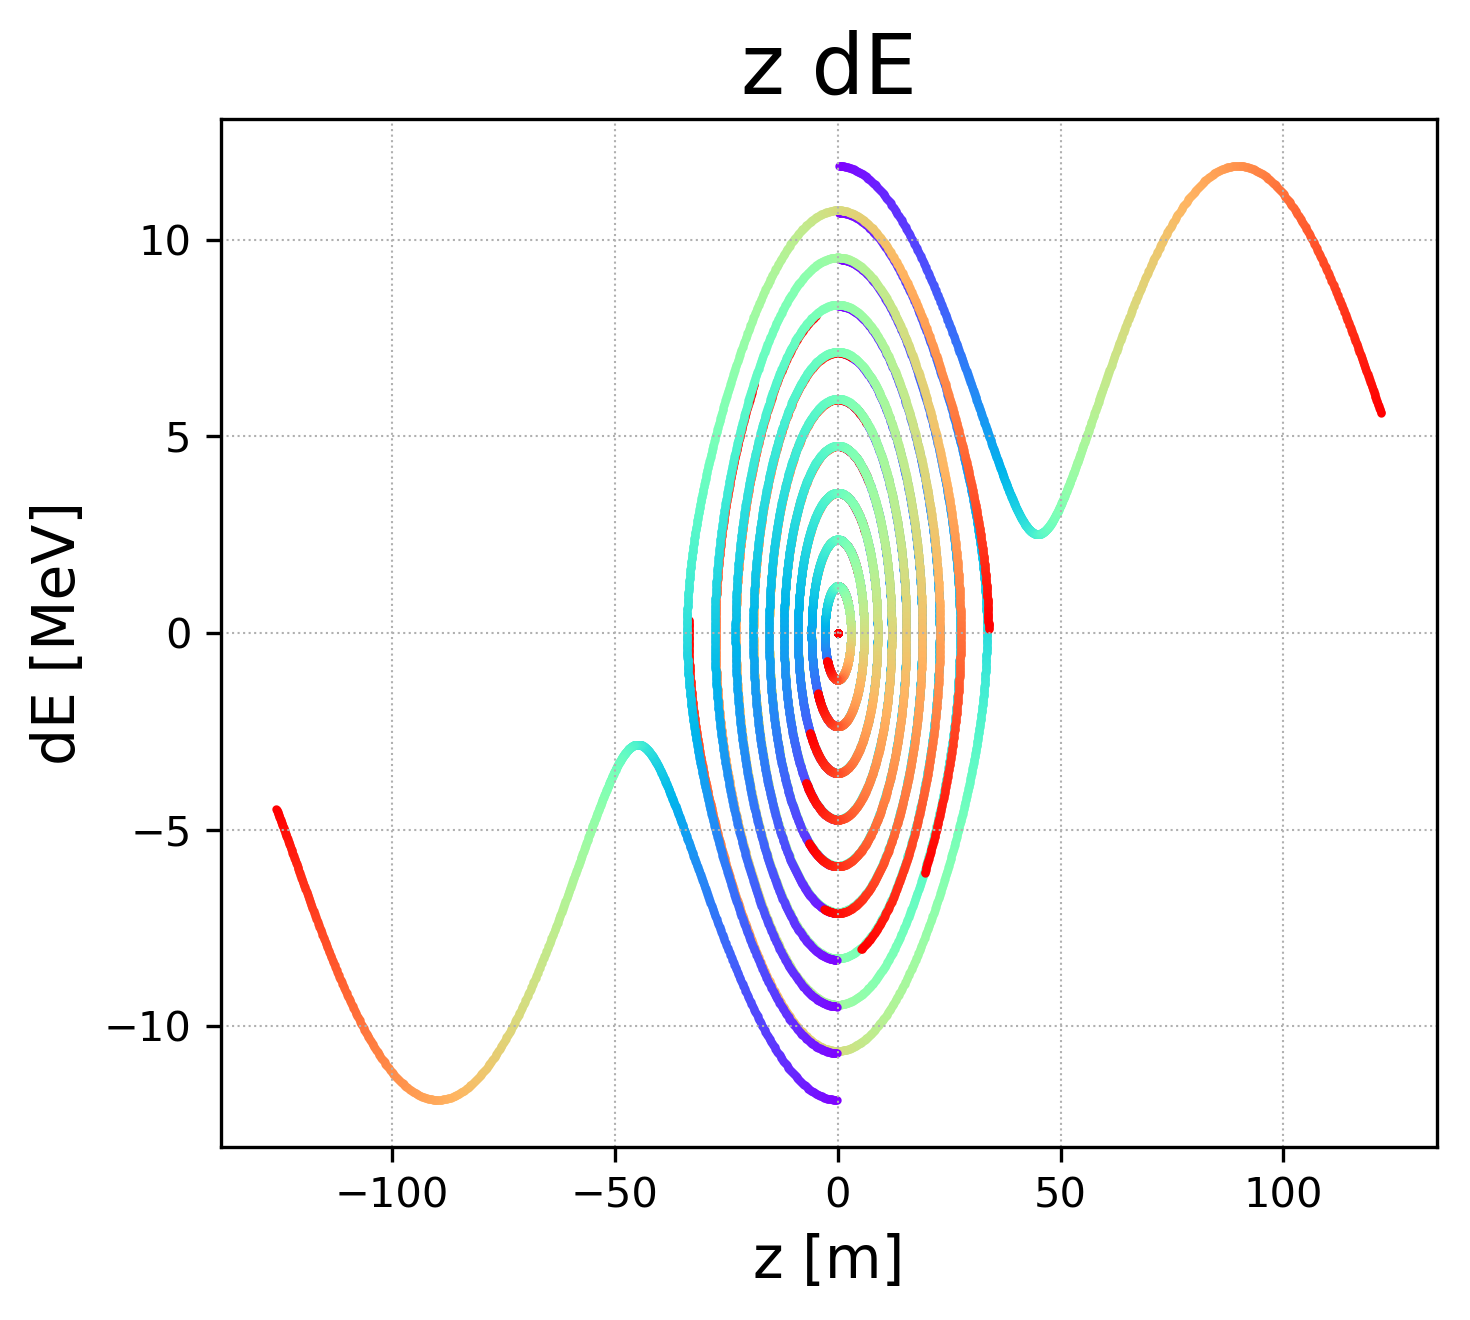

In [19]:
parameter1 = 'z'
parameter2 = 'dE'
multi1 = 1
multi2 = 1E3

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = parameter1 + ' ' + parameter2
ax1.set_title(tit);

ax1.set_ylabel('dE [MeV]');
ax1.set_xlabel('z [m]');

colors = cm.rainbow(np.linspace(0, 1, len(dd[parameter1])))
c_it = int(0)

turns = seq_start_to_end(len(dd[parameter1]), 0, len(dd[parameter1])-1)

for key, value in sorted(ddd.iteritems(), reverse=True):
    for t in turns:
        ax1.scatter(ddd[key][parameter1][t]*multi1, ddd[key][parameter2][t]*multi2, color=colors[c_it]);
        c_it = c_it + 1;
    c_it = 0;

#ax1.legend(loc=3)
ax1.grid(lw=0.5, ls=':');
#ax1.set_xlim(-1,turn_tot)

fig1.tight_layout()

#savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
#plt.savefig(savename, dpi = 800);

('seq_start_to_end::interval = ', 1)


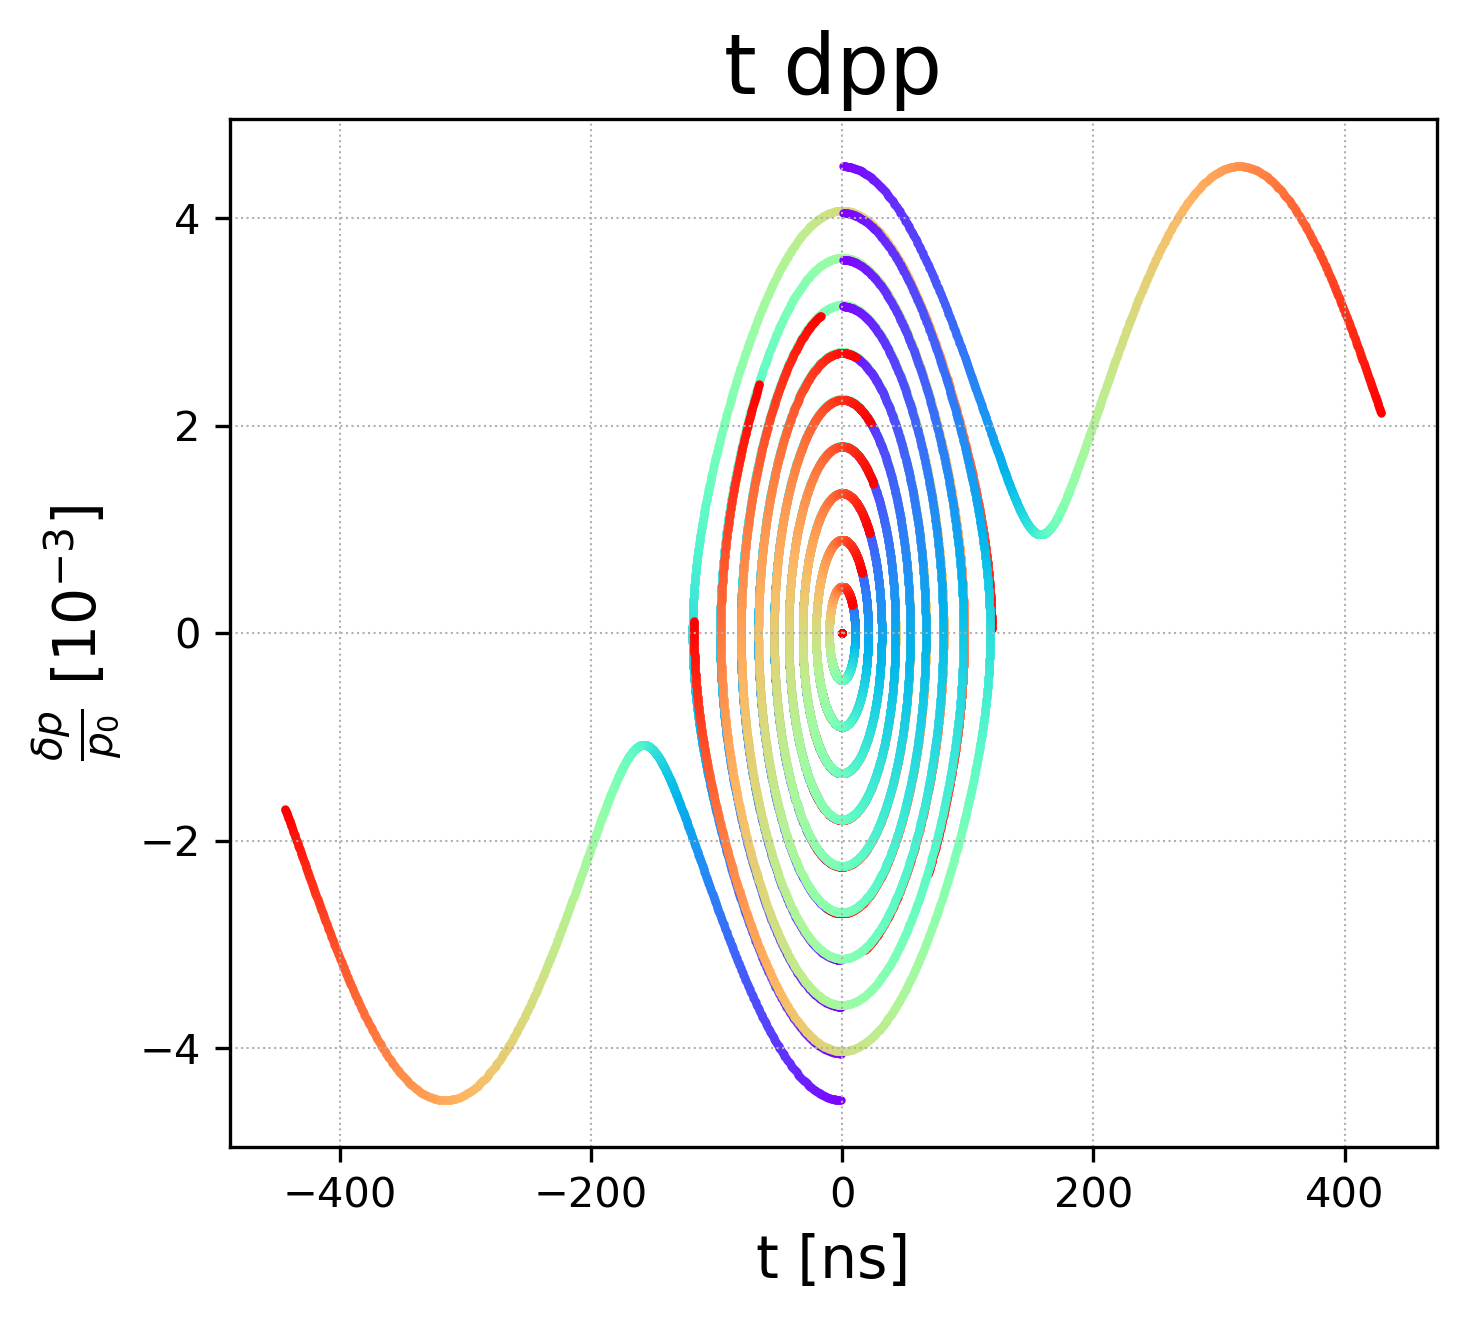

In [21]:
parameter1 = 'z'
parameter2 = 'dE'
multi1 = 1E9
multi2 = 1E3

fig1 = plt.figure(facecolor='w', edgecolor='k')
ax1 = fig1.add_subplot(111)

tit = 't dpp'
ax1.set_title(tit);

ax1.set_ylabel(r'$\frac{\delta p}{p_0}$ $[10^{-3}]$');
ax1.set_xlabel('t [ns]');

colors = cm.rainbow(np.linspace(0, 1, len(dd[parameter1])))
c_it = int(0)

turns = seq_start_to_end(len(dd[parameter1]), 0, len(dd[parameter1])-1)

for key, value in sorted(ddd.iteritems()):
    for t in turns:
        ax1.scatter(z_to_time(ddd[key][parameter1][t])*multi1, dpp_from_dE(ddd[key][parameter2][t]*1E9)*multi2, color=colors[c_it]);
        c_it = c_it + 1;
    c_it = 0;

#ax1.legend(loc=3)
ax1.grid(lw=0.5, ls=':');
#ax1.set_xlim(-1,turn_tot)

fig1.tight_layout()

#savename = save_folder + '/'+ main_label + '_' + parameter + '.png'
#plt.savefig(savename, dpi = 800);

## Check input parameters

In [40]:
dpp_rms = 1.5E-03
longitudinal_cut = 5
max_dpp = dpp_rms * longitudinal_cut
dpps = seq_even_about_start(21, 0, max_dpp)
dpps

array([-0.0075 , -0.00675, -0.006  , -0.00525, -0.0045 , -0.00375,
       -0.003  , -0.00225, -0.0015 , -0.00075,  0.     ,  0.00075,
        0.0015 ,  0.00225,  0.003  ,  0.00375,  0.0045 ,  0.00525,
        0.006  ,  0.00675,  0.0075 ])

In [41]:
PO_dpps = []
for key, value in sorted(ddd.iteritems()):
    PO_dpps.append( dpp_from_dE(ddd[key]['dE'][0]*1E9) )
PO_dpps = np.array(PO_dpps)
PO_dpps

array([-0.00750105, -0.00675091, -0.00600076, -0.005251  , -0.00450086,
       -0.00375071, -0.00300057, -0.00225043, -0.00150029, -0.00075014,
       -0.        ,  0.00075014,  0.00150029,  0.00225043,  0.00300057,
        0.00375071,  0.00450086,  0.005251  ,  0.00600076,  0.00675091,
        0.00750105])

In [42]:
dpp_diff = PO_dpps - dpps
dpp_diff

array([-1.04814474e-06, -9.05425128e-07, -7.62705514e-07, -9.99037299e-07,
       -8.56317685e-07, -7.13598071e-07, -5.70878457e-07, -4.28158843e-07,
       -2.85439228e-07, -1.42719614e-07, -0.00000000e+00,  1.42719614e-07,
        2.85439228e-07,  4.28158843e-07,  5.70878457e-07,  7.13598071e-07,
        8.56317685e-07,  9.99037299e-07,  7.62705514e-07,  9.05425128e-07,
        1.04814474e-06])

## Test initial distn maker 

In [ ]:
def seq_even_about_start(n_vals, start, stop):
    n_mp = n_vals
    interval = 2*(stop-start)/(n_mp-1) 

    positive = np.arange(start, stop+interval, interval)
    negative = np.arange((-1*stop), start, interval)

    positions = np.concatenate((negative, positive), axis=None)
    
    return positions


h_main = 7# np.atleast_1d(parameters['harmonic_number'])[0]
R = 100
max_dpp = 5 * 1.5E-3
# min_dpp = -1* max_dpp                        
dpps = seq_even_about_start(21, 0, max_dpp)
print dpps
print max_dpp

            
        
            #dE[i] = dpps[i] * parameters['energy'] * parameters['beta']**2 * 1E9



# Plot initial distn and expectation

## Load initial distn from output

In [ ]:
dd0 = dict()
dd0 = add_bunch_file(dd0, 'bunch_output/mainbunch_-000001.mat', 'Initial Distn')

save_folder = 'Plots/'
sc = 'NoSC'
Case = 'RF_Test'
legend_label = '2023'    
main_label = 'Longitudinal_Check'

In [ ]:
# PS Pre-LIU 1.4 GeV Injection
LIU = True

if LIU:
    print 'PS LIU 2 GeV Injection'
    Lorentz_Gamma = 3.1316
    
else:
    print 'PS Pre-LIU 1.4 GeV Injection'
    Lorentz_Gamma = 2.4921
        
print '----------------------'
print 'Lorentz Gamma =\t', Lorentz_Gamma
Lorentz_Beta = LorentzBeta(Lorentz_Gamma)
print 'Lorentz Beta =\t', round_sig(Lorentz_Beta)
Beam_Energy = E_from_gamma(Lorentz_Gamma)
print 'Energy =\t', round_sig(Beam_Energy/1E9), 'GeV'
Beam_Momentum = RelativisticMomentum(938.27208816E6, Lorentz_Gamma)
print 'Momentum =\t', round_sig(Beam_Momentum)/1E9, 'GeV/c'


In [ ]:
dd0['Initial Distn'].dE

In [ ]:
# Create dd dictionary
dd1 = dict()

dd1 = add_input_file(dd1, '00_00/bunch_output/mainbunch_-000001.mat', '1.3')
dd1 = add_input_file(dd1, '00_01/bunch_output/mainbunch_-000001.mat', '1.6')
dd1 = add_input_file(dd1, '00_02/bunch_output/mainbunch_-000001.mat', '1.9')
dd1 = add_input_file(dd1, '00_03/bunch_output/mainbunch_-000001.mat', '2.3')
dd1 = add_input_file(dd1, '00_04/bunch_output/mainbunch_-000001.mat', '2.6')

save_folder = 'Plots/'
sc = 'SbS'
Case = 'Tomo'
legend_label = '2023'    
main_label = 'MD211'

In [ ]:
dd1['1.3']['particles']['z'][0][0]

In [ ]:
dd1['1.3']['particles']['x'][0][0][0]

In [ ]:
# If using add_bunch_file, access like:
# dd1['2021'].x

## Longitudinal Distn

In [ ]:
bin_size = 256
turn = -1
zdE_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['z'][0][0][0])
    dE = np.array(dd1[key]['particles']['dE'][0][0][0])*1E3 #dE in GeV
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('z [m]')
    plt.ylabel('dE [MeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_z_dE_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

In [ ]:
bin_size = 256
turn = -1
tdpp_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['z'][0][0][0])
    dE = np.array(dd1[key]['particles']['dE'][0][0][0])*1E9 #in GeV?
    t = z_to_time(z, Lorentz_Beta)*1E9
    dpp = dpp_from_dE(dE, Beam_Energy, Lorentz_Beta)*1E3
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(t, bins=bin_size, range=(np.min(t), np.max(t))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-105, 105)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(t, dpp, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(t), np.max(t)], [np.min(dpp), np.max(dpp)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('t [ns]')
    plt.ylabel(r'$\frac{\delta p}{p_0} [10^{-3}]$')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-105, 105)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dpp, bins=bin_size, range=(np.min(dpp), np.max(dpp)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_t_dpp_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

## Transverse

In [ ]:
bin_size = 256
turn = -1
xxp_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['x'][0][0][0])*1E3
    dE = np.array(dd1[key]['particles']['xp'][0][0][0])*1E3
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('x [mm]')
    plt.ylabel('xp [mrad]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_x_xp_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

In [ ]:
bin_size = 256
turn = -1
yyp_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['y'][0][0][0])*1E3
    dE = np.array(dd1[key]['particles']['yp'][0][0][0])*1E3
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('y [mm]')
    plt.ylabel('yp [mrad]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_y_yp_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

In [ ]:
bin_size = 256
turn = -1
xy_gifnames = []

for key, value in sorted(dd1.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd1[key]['particles']['x'][0][0][0])*1E3
    dE = np.array(dd1[key]['particles']['y'][0][0][0])*1E3
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_x_y_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

# Outputs from PyORBIT distn generator

In [ ]:
print 'E = ', Beam_Energy, ' eV'
print Lorentz_Gamma, Lorentz_Beta

## Tomo

###  dE in GeV - left in GeV

In [ ]:
dE =  0.0006314289037996632
dpp =  0.0003221746813320432
dE =  -0.0008589983359948103
dpp =  -0.000438287689237122
dE =  0.00026159828499872616
dpp =  0.0001334755878283546
dE =  -0.0022756252658838213
dpp =  -0.0011610948444955513
dE =  0.0020652510564129543
dpp =  0.001053755374463528
dE =  0.0015244004879357692
dpp =  0.0007777965792629266
dE =  0.0008149801230596197
dpp =  0.0004158282268338923
dE =  -0.000520855282548129
dpp =  -0.0002657565779223429
dE =  0.0009229846439224305
dpp =  0.0004709354952563656
dE =  -0.0009561016538549669
dpp =  -0.00048783282456372047


In [ ]:
dpp_test = dpp_from_dE(0.0006314289037996632*1E9, Beam_Energy, Lorentz_Beta)
print dpp_test

## Parabolic Original

### dE in  KeV? - later divided by ?

In [ ]:
# Output from parabolic distn

dE =  -3171.5437690860294
dpp =  -1.6182203522632976e-06
dE =  -3599.1492231786615
dpp =  -1.8363979651016328e-06
dE =  2249.6692689658676
dpp =  1.1478512869305169e-06
dE =  989.0065737753488
dpp =  5.04621938945106e-07
dE =  -1101.9610697028736
dpp =  -5.622548387244577e-07
dE =  454.19920036693054
dpp =  2.3174656997632794e-07
dE =  -2486.5513036274683
dpp =  -1.2687158744892151e-06
dE =  1175.0607906370972
dpp =  5.99552591734695e-07
dE =  320.46384650462005
dpp =  1.63510629628738e-07
dE =  1427.544861547296
dpp =  7.283778238351228e-07

In [ ]:
dpp_test = dpp_from_dE(3171.5437690860294*1E3, Beam_Energy, Lorentz_Beta)
print dpp_test

### Edited - dE in KeV - later divided by 1E6 

In [ ]:
636.3854431612198/1E6

In [ ]:
# Parabolic edited (KeV from Joho)
dE =  -636.3854431612198
dpp =  -0.0003247036619974989
dE =  1131.9842946700558
dpp =  0.0005775736226416271
dE =  679.534959709447
dpp =  0.00034671988846401405
dE =  1880.536282910152
dpp =  0.000959508147368794
dE =  -1958.1334708281088
dpp =  -0.000999100648027684
dE =  -698.6187612933395
dpp =  -0.00035645703805741504
dE =  -1474.6581001066922
dpp =  -0.0007524164646513022
dE =  -360.66397779601806
dpp =  -0.00018402198793111566
dE =  1459.3810704179018
dpp =  0.0007446216485729305
dE =  -2296.2778050861243
dpp =  -0.0011716324128522738



In [ ]:
dpp_test = dpp_from_dE(636.3854431612198*1E3, Beam_Energy, Lorentz_Beta)
print dpp_test

In [ ]:
# Create dd dictionary
dd2 = dict()

dd2 = add_input_file(dd2, '../02_Initial_Setup_Parabolic/Dpp_Test_00/bunch_output/mainbunch_-000001.mat', 'New 1.3')
dd2 = add_input_file(dd2, '../02_Initial_Setup_Parabolic/00_00/bunch_output/mainbunch_-000001.mat', 'Old 1.3')

save_folder = 'Plots/'
sc = 'SbS'
Case = 'Parabolic_Test'
legend_label = '2023'    
main_label = 'MD211'

In [ ]:
bin_size = 256
turn = -1
zdE_gifnames = []

for key, value in sorted(dd2.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd2[key]['particles']['z'][0][0][0])
    dE = np.array(dd2[key]['particles']['dE'][0][0][0])*1E3 #dE in GeV
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('z [m]')
    plt.ylabel('dE [MeV]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_z_dE_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)

In [ ]:
bin_size = 256
turn = -1
xy_gifnames = []

for key, value in sorted(dd2.iteritems()):
    f, ax = plt.subplots(1, figsize=(6,6))
    gridspec.GridSpec(3,3)
    #f.subplots_adjust(hspace = 0)	# Horizontal spacing between subplots
    f.subplots_adjust(wspace = 0)	# Vertical spacing between subplots

    my_cmap = plt.cm.jet
    my_cmap.set_under('w',1)

    title = str( main_label + ' ' + key + ' turn ' + str(turn) ) 
    
    z = np.array(dd2[key]['particles']['x'][0][0][0])*1E3
    dE = np.array(dd2[key]['particles']['y'][0][0][0])*1E3
    
    # First subplot
    plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=1)   
    plt.hist(z, bins=bin_size, range=(np.min(z), np.max(z))) #, norm=mcolors.PowerNorm(gamma))
    plt.title(title)
    plt.ylabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)

    # Main plot
    plt.subplot2grid((3,3), (1,0), colspan=2, rowspan=2)
    plt.hist2d(z, dE, bins=bin_size, cmap=my_cmap, vmin=1, range=[[np.min(z), np.max(z)], [np.min(dE), np.max(dE)]]) #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.xlim(-30, 30)
    #plt.ylim(-10, 10)

    # Second subplot
    plt.subplot2grid((3,3), (1,2), colspan=1, rowspan=2)    
    plt.hist(dE, bins=bin_size, range=(np.min(dE), np.max(dE)), orientation=u'horizontal') #, norm=mcolors.PowerNorm(gamma))
    plt.xlabel('Frequency')
    plt.grid(which='both', ls=':', lw=0.5)
    #plt.ylim(-10, 10)

    current_axis = plt.gca()
    #current_axis.axes.get_yaxis().set_visible(False)

    #ax.xaxis.label.set_size(fontsize)
    #ax.yaxis.label.set_size(fontsize)

    #ax.tick_params(labelsize=fontsize)

    plt.tight_layout()
    savename = str(save_folder + Case +'_x_y_turn_' + str(turn) + '_' + key + '_hist.png' )
    zdE_gifnames.append(savename)
    f.savefig(savename, dpi=500)